In [1]:
# !pip install tensorflow-gpu --upgrade
# !pip install tikzplotlib

In [2]:
# Import libraries
from mpl_toolkits import mplot3d
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from src.layers import CADenseAdd, CADenseMul
from src.optimizers import SVDAdam, SVDSGD
from src.models import wrap_model

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import matplotlib.dates as mdates
import tensorflow as tf

import types 
import os

plt.style.use('dark_background')

In [3]:
# Directories
covid_data = 'IndianCovidData/CovidData'
state_data = 'IndianCovidData/StateData'

In [4]:
smoothing_window = 5

# Covid data per state
covid_per_state = {
    file[:-4]: pd.read_csv(os.path.join(covid_data, file), delimiter=',', index_col=0, usecols=[1, 2, 3, 4, 5]) 
    for file in os.listdir(covid_data) if file.endswith('csv')
}
# Shift and scale
for state, df in covid_per_state.items():
    for i in ['Confirmed', 'Recovered', 'Deceased']:
        scaled = df[i].apply(lambda x: np.log(1 + x))
        shifted = scaled - scaled.shift(1)
        shifted = shifted.rolling(smoothing_window).mean().dropna()
        shifted[shifted < 10e-6] = np.nan
        shifted = shifted.interpolate()
        df[f'ShiftedScaled{i}'] = shifted
        covid_per_state[state] = df.dropna()

    
# Full dataframe
covid_df = pd.concat(covid_per_state, axis=0)
# Print header
covid_df.head(5)

State  Confirmed  Recovered  Deceased  \
              Date                                                         
MadhyaPradesh 2020-04-05  Madhya Pradesh        193          3        13   
              2020-04-06  Madhya Pradesh        256         11        15   
              2020-04-07  Madhya Pradesh        290         21        21   
              2020-04-08  Madhya Pradesh        341         25        24   
              2020-04-09  Madhya Pradesh        411         25        33   

                          ShiftedScaledConfirmed  ShiftedScaledRecovered  \
              Date                                                         
MadhyaPradesh 2020-04-05                0.212633                0.277259   
              2020-04-06                0.190791                0.496981   
              2020-04-07                0.198238                0.618208   
              2020-04-08                0.158277                0.651619   
              2020-04-09                0.165613                0.651619   

                          ShiftedScaledDeceased  
              Date                               
MadhyaPradesh 2020-04-05               0.169460  
              2020-04-06               0.165336  
              2020-04-07               0.178764  
              2020-04-08               0.204330  
              2020-04-09               0.208291

In [5]:
# States in data
states = covid_df.State.unique()

In [6]:
# State data per property
property_per_state = {
    prop: pd.read_csv(
        os.path.join(state_data, prop), delimiter=';', skiprows=0, nrows=36, header=0, index_col=0, na_values=['-', '.'])
    for prop in os.listdir(state_data) if prop.endswith('csv')
}
# Map states between two dataset
mapping = {
    idx: state for idx in pd.concat([pd.Series(df.index) for df in property_per_state.values()]).values for state in states 
    if any([token in state for token in str(idx).split('&')])
}
# Get state data rows and most recent data
for prop, df in property_per_state.items():
    property_per_state[prop] = df.T[list(set(df.index) & set(mapping.keys()))].T[df.columns[-1]]

In [7]:
# Concatenate all properties
state_df = pd.concat(property_per_state.values(), axis=1).applymap(lambda s: float(str(s).replace(',', '.'))).fillna(0)
state_df.columns = [''.join(df.index.name.split(': ')[1:]) for df in property_per_state.values()]
state_df = state_df.divide(state_df.max())
state_df.head(2)

,STATE-WISE POPULATION IN RURAL AREA,STATE-WISE POPULATION IN URBAN AREA,STATE-WISE LITERACY RATE,STATE-WISE LIFE EXPECTANCY*,STATE-WISE POVERTY RATE,STATE-WISE TOTAL POPULATION,STATE-WISE SEX RATIO,STATE-WISE DENSITY OF POPULATION,STATE-WISE BIRTH RATE (Concld.),STATE-WISE DEATH RATE (Concld.)
Daman and Diu,0.000386,0.003601,0.926596,0.000000,0.000000,0.001216,0.570111,0.236660,0.000000,0.0000
Himachal Pradesh,0.039764,0.013558,0.880851,0.923291,0.161017,0.034357,0.896679,0.013286,0.599237,0.8625


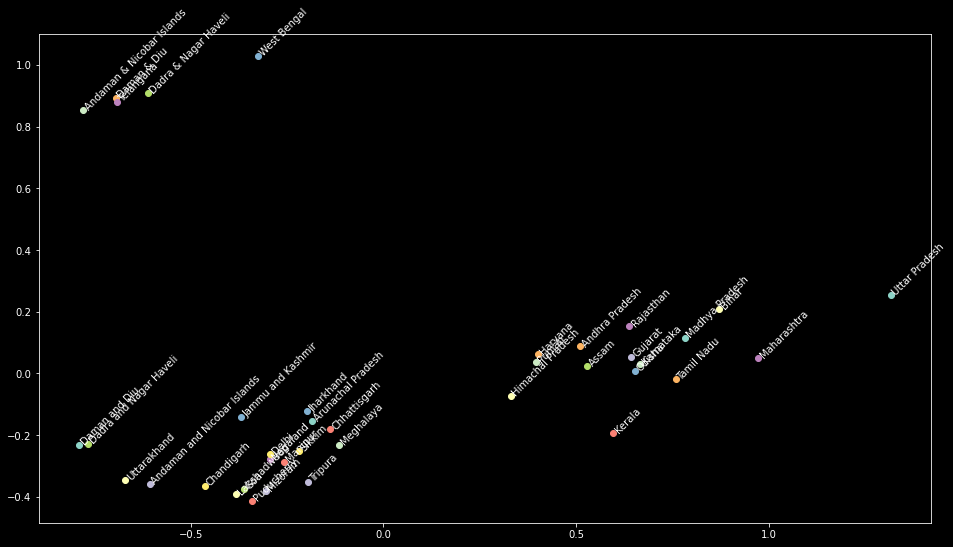

In [8]:
# Get 2d embedding of state properties
x, y = zip(*PCA(2).fit_transform(state_df.values))
plt.figure(figsize=(16, 9))
for i, j, k in zip(x, y, state_df.index):
    plt.scatter(i, j)
    plt.text(i, j , k, rotation=45)
plt.show()

(array([1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00,
        1.e+01]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

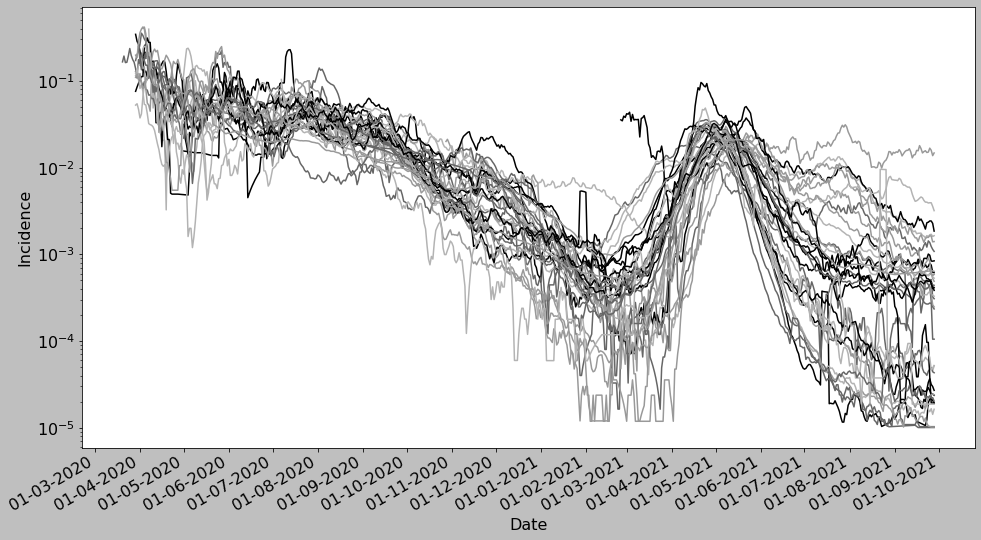

In [9]:
plt.style.use('grayscale')
fig, ax = plt.subplots(1, figsize=(16, 9))
for state, df in covid_per_state.items():
    ax.plot(pd.to_datetime(df.index), df.ShiftedScaledConfirmed, label=df.State[0])

# set monthly locator
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
# set formatter
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
# set font and rotation for date tick labels
plt.gcf().autofmt_xdate()
plt.yscale('log')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Incidence', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.show()
# import tikzplotlib
# tikz = tikzplotlib.get_tikz_code(fig)
# tikzplotlib.save('covid_incidence_plot.tex', fig)
# with open('covid_incidence_plot.tex', 'w') as f:
#     f.write(tikz)

In [10]:
def split_series(series, percentage=0.8):
    return series[:int(percentage * series.size)].values, series[int(percentage * series.size):].values, 

percentage = 0.6
train_series, test_series = zip(*[split_series(series.ShiftedScaledConfirmed, percentage) for series in covid_per_state.values()])

## Convnet

In [11]:
learning_rate = 5*10e-5
epochs = 75
verbose = 0

def build_loss():
    def loss_fn(y_true, y_pred):
        return tf.reduce_sum(
            (tf.math.exp(y_true) - tf.math.exp(y_pred))**2
        )
    return loss_fn

loss = build_loss()

In [25]:
def lstm(nn):
#     nn = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='relu', return_sequences=True))(nn)
#     nn = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, activation='elu'))(nn)
    nn = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='elu', use_bias=False))(nn)
    return nn

def mlp(nn, nc=None, t=None):
    n_layers = 9
    if (nc is not None):
        if t is None:
            for i in range(n_layers):
                nn = CADenseMul(64, 24, 'relu', use_bias=False)([nn, nc])
        else:
            for i in range(n_layers):
                nn = tf.keras.layers.Dense(64, 'relu', use_bias=False)(nn)#  * tf.keras.layers.Dense(64, 'sigmoid', use_bias=True)(nc)
    else:
        for i in range(n_layers):
            nn = tf.keras.layers.Dense(64, 'relu', use_bias=False)(nn)
    return nn

### Only TS data

In [16]:
def window(series, stride, window_size, target_size):
    for serie in series:
        for idx in np.arange(0, serie.size - window_size - target_size, stride):
            yield serie[idx:idx + window_size, np.newaxis], serie[idx + window_size:idx + window_size + target_size, ...]

window_size = 14
target_size = 1
stride = 7

In [124]:
batch_size = 64

dataset = tf.data.Dataset.from_generator(
    lambda: window(train_series, stride, window_size, target_size), 
    output_shapes=((window_size, 1), (target_size)),
    output_types=(tf.float32, tf.float32)
).batch(batch_size).shuffle(128 * batch_size)

#### Regular feed-forward

In [125]:
nn = input_layer = tf.keras.layers.Input(shape=(window_size, 1))
# nn = convs(nn)
# nn = tf.reduce_max(nn, axis=-2)
nn = tf.reshape(nn, [-1, window_size])
nn = mlp(nn)
nn = tf.keras.layers.Dense(target_size, use_bias=True)(nn)

In [126]:
model = tf.keras.Model(input_layer, nn)
opt = tf.keras.optimizers.Adam(learning_rate)
model.compile(loss=loss, optimizer=opt)
history = model.fit(dataset, epochs=epochs, verbose=verbose)

KeyboardInterrupt: 

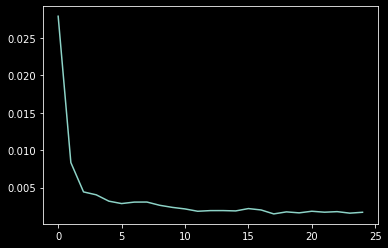

In [17]:
plt.plot(history.history['loss'])
plt.show()

In [18]:
def predict(model, series, forecast=True):
    predictions = []
    for serie in series:
        prediction = serie[np.newaxis, :window_size, np.newaxis]
        for i in range(serie.size - window_size):
            if forecast:
                value = model(prediction[:, i:window_size + i, :])
            else:
                value = model(serie[np.newaxis, i:window_size + i, np.newaxis])
            prediction = np.concatenate([prediction, value[..., np.newaxis]], axis=-2)
        predictions.append(prediction)
    return predictions

In [19]:
train_predictions = predict(model, train_series, False)

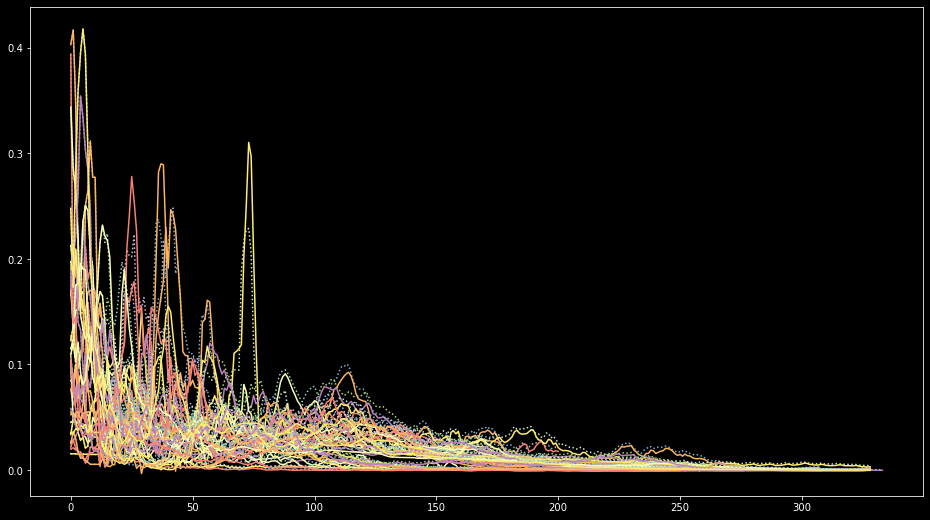

In [20]:
plt.figure(figsize=(16, 9))
for true, pred in zip(train_series, train_predictions):
    plt.plot(true, linestyle='dotted')
    plt.plot(pred[0, :, 0])
plt.show()

In [21]:
test_predictions = predict(model, test_series, False)

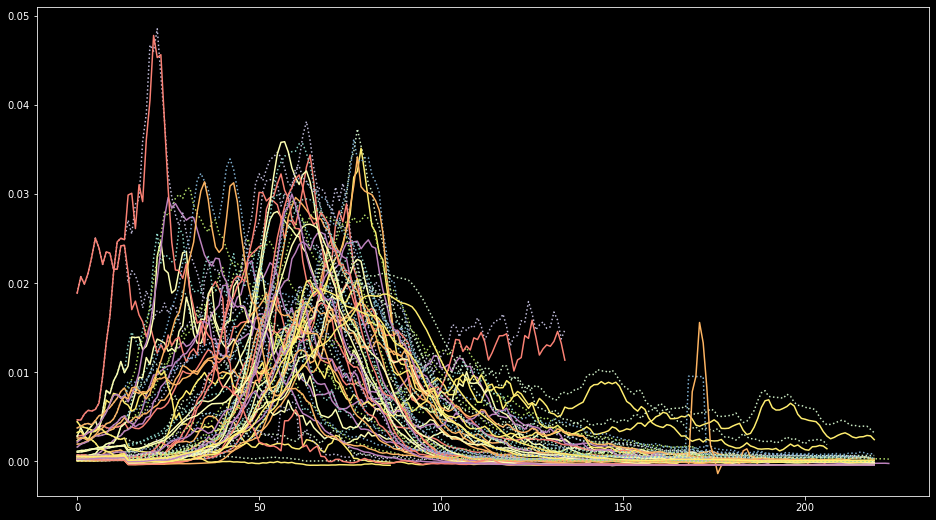

In [22]:
plt.figure(figsize=(16, 9))
for true, pred in zip(test_series, test_predictions):
    plt.plot(true, linestyle='dotted')
    plt.plot(pred[0, :, 0])
plt.show()

In [23]:
test_ae = np.sqrt(np.mean([np.mean(np.abs(true - pred[0, :, 0])) for true, pred in zip(test_series, test_predictions)]))

In [24]:
test_ae

0.03284263144973398

### TS data and state description

In [13]:
inverse_mapping = {value: key for key, value in mapping.items()}

In [17]:
def window(states, series, stride, window_size, target_size):
    for state, serie in zip(states, series):
        for idx in np.arange(0, serie.size - window_size - target_size, stride):
            yield (serie[idx:idx + window_size, np.newaxis], state_df.loc[inverse_mapping[state]].values), serie[idx + window_size:idx + window_size + target_size, ...]

In [18]:
batch_size = 64

dataset = tf.data.Dataset.from_generator(
    lambda: window([covid_df.loc[key].State[0] for key in covid_per_state.keys()], train_series, stride, window_size, target_size), 
    output_shapes=(((window_size, 1), state_df.columns.size), (target_size)),
    output_types=((tf.float32, tf.float32), tf.float32)
).batch(batch_size, drop_remainder=True).shuffle(128 * batch_size)

test_dataset = tf.data.Dataset.from_generator(
    lambda: window([covid_df.loc[key].State[0] for key in covid_per_state.keys()], test_series, stride, window_size, target_size), 
    output_shapes=(((window_size, 1), state_df.columns.size), (target_size)),
    output_types=((tf.float32, tf.float32), tf.float32)
).batch(batch_size, drop_remainder=True).shuffle(128 * batch_size)

2022-03-03 10:07:36.913008: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-03 10:07:40.397353: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10415 MB memory:  -> device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:3c:00.0, compute capability: 6.1
2022-03-03 10:07:40.401434: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10415 MB memory:  -> device: 1, name: GeForce GTX 1080 Ti, pci bus id: 0000:5e:00.0, compute capability: 6.1
2022-03-03 10:07:40.403330: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/

In [19]:
def predict(model, states, series, forecast=True):
    predictions = []
    for state, serie in zip(states, series):
        prediction = serie[np.newaxis, :window_size, np.newaxis]
        for i in range(serie.size - window_size):
            if forecast:
                value = model((prediction[:, i:window_size + i, :], state_df.loc[inverse_mapping[state]].values[np.newaxis, ...]))
            else:
                value = model((serie[np.newaxis, i:window_size + i, np.newaxis], state_df.loc[inverse_mapping[state]].values[np.newaxis, ...]))
            prediction = np.concatenate([prediction, value[..., np.newaxis]], axis=-2)
        predictions.append(prediction)
    return predictions

#### Regular feedforward

In [26]:
nn = input_layer = tf.keras.layers.Input(shape=((window_size, 1)))
nc = context_layer = tf.keras.layers.Input(shape=(len(state_df.columns)))
# nn = convs(nn)
# nn = tf.reduce_max(nn, axis=-2)
nn = tf.reshape(nn, [-1, window_size])
nn = tf.concat([nn, nc], axis=-1)
nn = mlp(nn)
nn = tf.keras.layers.Dense(target_size, use_bias=True)(nn)

In [27]:
model1 = tf.keras.Model((input_layer, context_layer), nn)
opt = tf.keras.optimizers.Adam(learning_rate*10)
model1.compile(loss=loss, optimizer=opt)
history1 = model1.fit(dataset, epochs=epochs, verbose=1)

Epoch 1/75
22/22 [==============================] - 1s 5ms/step - loss: 0.0640
Epoch 2/75
22/22 [==============================] - 1s 2ms/step - loss: 0.0484
Epoch 3/75
22/22 [==============================] - 1s 3ms/step - loss: 0.0424
Epoch 4/75
22/22 [==============================] - 1s 3ms/step - loss: 0.0348
Epoch 5/75
22/22 [==============================] - 1s 2ms/step - loss: 0.0217
Epoch 6/75
22/22 [==============================] - 1s 2ms/step - loss: 0.0287
Epoch 7/75
22/22 [==============================] - 1s 2ms/step - loss: 0.0204
Epoch 8/75
22/22 [==============================] - 1s 3ms/step - loss: 0.0199
Epoch 9/75
22/22 [==============================] - 1s 2ms/step - loss: 0.0189
Epoch 10/75
22/22 [==============================] - 1s 2ms/step - loss: 0.0160
Epoch 11/75
22/22 [==============================] - 1s 3ms/step - loss: 0.0193
Epoch 12/75
22/22 [==============================] - 1s 3ms/step - loss: 0.0140
Epoch 13/75
22/22 [==============================

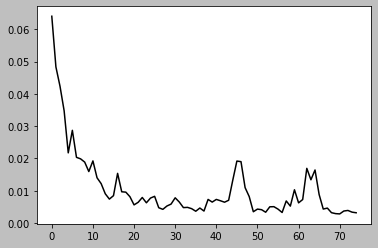

In [28]:
plt.plot(history1.history['loss'])
plt.show()

In [32]:
train_predictions = predict(model1, [covid_df.loc[key].State[0] for key in covid_per_state.keys()], train_series, False)

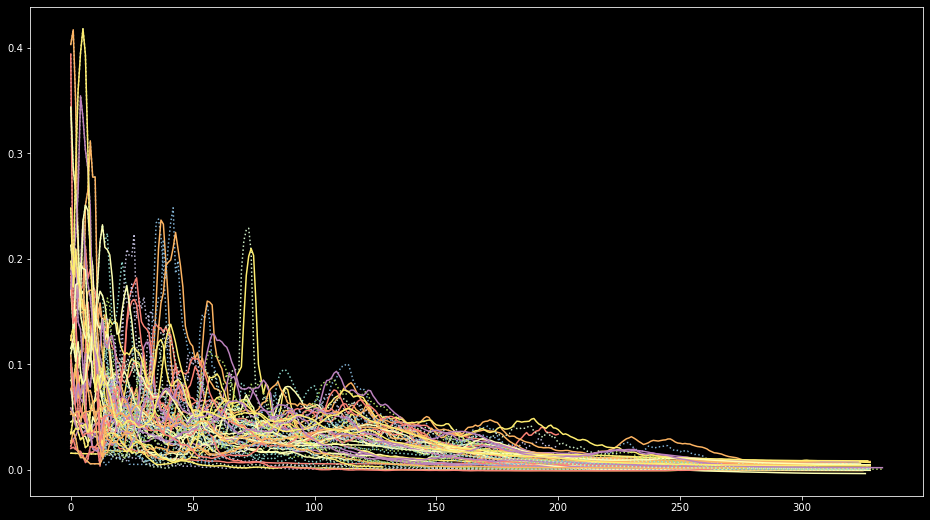

In [33]:
plt.figure(figsize=(16, 9))
for true, pred in zip(train_series, train_predictions):
    plt.plot(true, linestyle='dotted')
    plt.plot(pred[0, :, 0])
plt.show()

In [29]:
test_predictions = predict(model1, [covid_df.loc[key].State[0] for key in list(covid_per_state.keys())[:2]], test_series, False)

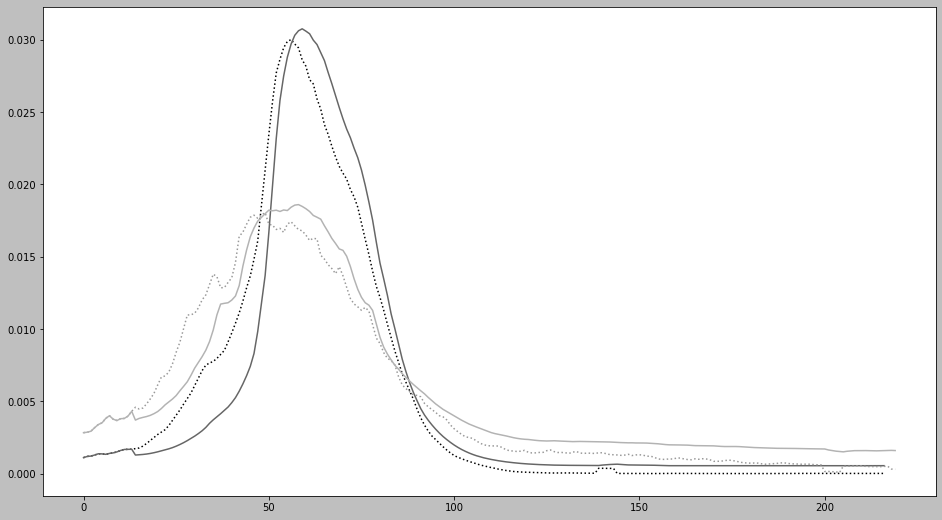

In [30]:
plt.figure(figsize=(16, 9))
for true, pred in zip(test_series, test_predictions):
    plt.plot(true, linestyle='dotted')
    plt.plot(pred[0, :, 0])
plt.show()

In [31]:
test_ae1 = np.sqrt(np.mean([np.mean(np.abs(true - pred[0, :, 0])) for true, pred in zip(test_series, test_predictions)]))

#### Gated feedforward

In [138]:
for i in range(5):
    nn = input_layer = tf.keras.layers.Input(shape=((window_size, 1)), batch_size=batch_size)
    nc = context_layer = tf.keras.layers.Input(shape=(len(state_df.columns)), batch_size=batch_size)
    nn = lstm(nn)
    # nn = tf.reduce_max(nn, axis=-2)
    # nn = tf.reshape(nn, [-1, window_size])
    nn = mlp(nn, nc, 'None')
    nn = tf.keras.layers.Dense(target_size, use_bias=False)(nn)

    modelg = tf.keras.Model((input_layer, context_layer), nn)
    opt = tf.keras.optimizers.Adam(learning_rate)
    modelg.compile(loss=loss, optimizer=opt)
    historyg = modelg.fit(dataset, epochs=int(epochs/1.5), verbose=verbose, validation_data=test_dataset)

#     plt.plot(historyg.history['loss'])
#     plt.show()

    test_predictions = predict(modelg, [covid_df.loc[key].State[0] for key in covid_per_state.keys()], test_series, False)

    # plt.figure(figsize=(16, 9))
    # for true, pred in zip(test_series, test_predictions):
    #     plt.plot(true, linestyle='dotted')
    #     plt.plot(pred[0, :, 0])
    # plt.show()

    test_ae_g = np.sqrt(np.mean([np.mean(np.abs(true - pred[0, :, 0])) for true, pred in zip(test_series, test_predictions)]))

    print(test_ae_g)

0.01735177774174
0.019525332682562464
0.01960304547083562
0.02166055323081442
0.01729460181110814


#### CA feedforward

In [37]:
nn = input_layer = tf.keras.layers.Input(shape=((window_size, 1)), batch_size=batch_size)
nc = context_layer = tf.keras.layers.Input(shape=(len(state_df.columns)), batch_size=batch_size)
# nn = convs(nn)
# nn = tf.reduce_max(nn, axis=-2)
nn = tf.reshape(nn, [-1, window_size])
nn = mlp(nn, nc)
nn = tf.keras.layers.Dense(target_size, use_bias=False)(nn)

In [38]:
model2 = tf.keras.Model((input_layer, context_layer), nn)
model2 = wrap_model(model2)
opt = SVDAdam(model2, None, learning_rate, learning_rate)
model2.compile(loss=loss, optimizer=opt)
history2 = model2.fit(dataset, epochs=epochs, verbose=verbose)

2021-10-14 08:46:25.920128: I tensorflow/core/util/cuda_solvers.cc:180] Creating CudaSolver handles for stream 0x555b32ae6700


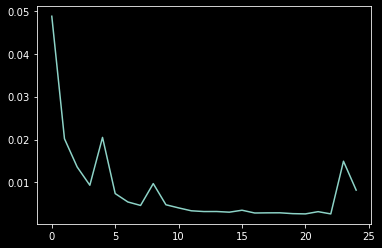

In [39]:
plt.plot(history2.history['loss'])
plt.show()

In [40]:
def predict(model, states, series, forecast=True):
    predictions = []
    for state, serie in zip(states, series):
        prediction = serie[np.newaxis, :window_size, np.newaxis]
        for i in range(serie.size - window_size):
            if forecast:
                value = model((prediction[:, i:window_size + i, :], state_df.loc[inverse_mapping[state]].values[np.newaxis, ...]))
            else:
                value = model((serie[np.newaxis, i:window_size + i, np.newaxis], state_df.loc[inverse_mapping[state]].values[np.newaxis, ...]))
            prediction = np.concatenate([prediction, value[..., np.newaxis]], axis=-2)
        predictions.append(prediction)
    return predictions

In [41]:
train_predictions = predict(model2, [covid_df.loc[key].State[0] for key in covid_per_state.keys()], train_series, False)

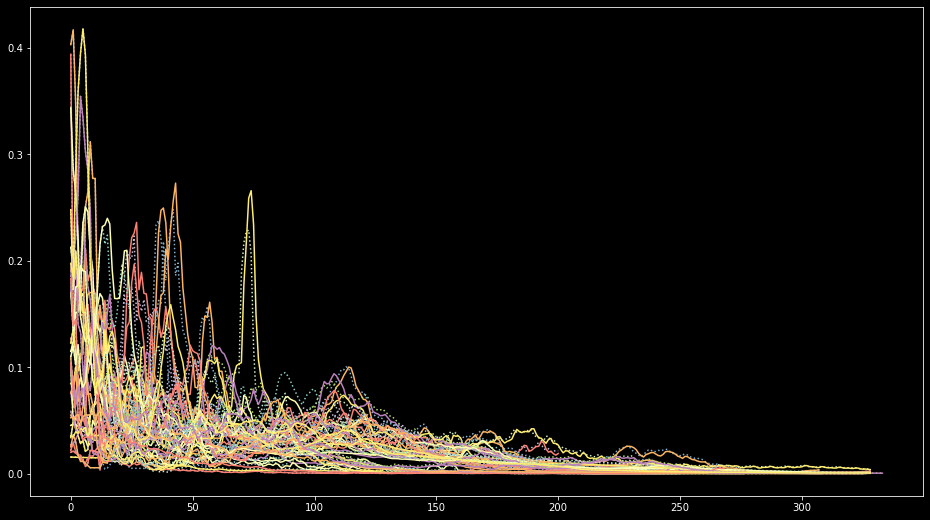

In [42]:
plt.figure(figsize=(16, 9))
for true, pred in zip(train_series, train_predictions):
    plt.plot(true, linestyle='dotted')
    plt.plot(pred[0, :, 0])
plt.show()

In [43]:
test_predictions = predict(model2, [covid_df.loc[key].State[0] for key in covid_per_state.keys()], test_series, False)

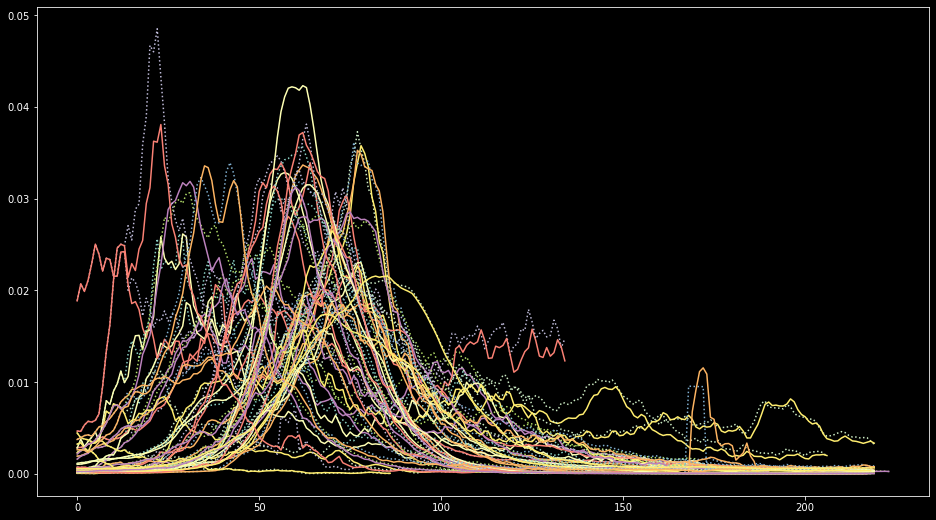

In [44]:
plt.figure(figsize=(16, 9))
for true, pred in zip(test_series, test_predictions):
    plt.plot(true, linestyle='dotted')
    plt.plot(pred[0, :, 0])
plt.show()

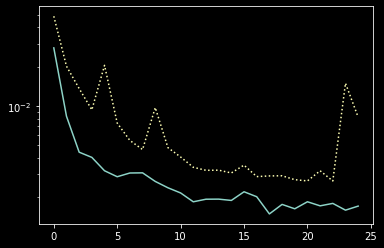

In [45]:
plt.plot(history.history['loss'])
plt.plot(history2.history['loss'], linestyle='dotted')
plt.yscale('log')
plt.show()

In [46]:
test_ae2 = np.sqrt(np.mean([np.mean(np.abs(true - pred[0, :, 0])) for true, pred in zip(test_series, test_predictions)]))



